# Model Summary 
## The goals of this model:
* Sentiment analysis of Tweets 
* Predidct positive/ neutral/negative signals of BTC price
* Label future Tweets

## Approach
* NLP and sentimental analysis 
* Bi-directional LSTM model

## Data 
* BTC price 
* Tweets 

1. Sample the data randomly and normlize the data. 
2. Find the derivative of BTC prices and define their positive/negative/neutral signals 
3. Defind a classification problem that predicts the movement
4. use the model to further label data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install vaderSentiment

In [3]:
# download stopwords
import  nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
import matplotlib.pyplot as plt
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True) 

In [4]:
tweets_raw_file   = './Bitcoin_tweets.csv'
tweets_clean_file = './Bitcoin_tweets_clean.csv'
bit_price_file2 = './BTC-USD.csv'
# bit_price_file2 = 'data/BTC-USD.csv'

In [114]:
# limit reading for testing
df_raw = pd.read_csv(tweets_raw_file,low_memory=False,nrows= 10000000)
#df_raw = pd.read_csv(tweets_raw_file,low_memory=False)
print(df_raw.shape)
# show the first 5 rows
df_raw.head(5)

(10000000, 13)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [115]:
# clean df
# order by date
df_raw = df_raw.sort_values(by = 'date')
# 1% random sample, not allow duplicate
dd = df_raw.sample(frac=0.01, replace=False, random_state=1)
#dd = df_raw.sample(frac=0.02, replace=False, random_state=1)
dd.reset_index(inplace=True)
# load stopwords files
stop_words = set(stopwords.words('english'))

for i,s in enumerate(tqdm(dd['text'],position=0, leave=True)):
    text = str(dd.loc[i, 'text'])
    text = text.replace("#", "")
    # remove URL
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text, flags=re.MULTILINE)
    # remove 'at'
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)
    # remove stopwords
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    text = ' '.join(filtered_sentence)
    dd.loc[i, 'text'] = text
# f = open(tweets_clean_file, 'a+', encoding='utf-8')
dd.to_csv(tweets_clean_file, header=True, encoding='utf-8',index=False)

100%|██████████| 100000/100000 [03:24<00:00, 488.54it/s]


## Sentiment anatweets_clean_fileh Vader
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

Use vader to calculate polarity

In [5]:
df_clean = pd.read_csv(tweets_clean_file)
df_clean.dropna(subset=['text'], inplace=True)

In [6]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(df_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
df_clean["compound"] = compound
df_clean.head(2)

100%|██████████| 45664/45664 [00:03<00:00, 11602.96it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound
0,3556230,Kyle Schneps,"New York, USA","Director of Public Policy at @FoundryServices,...",2021-10-23 13:16:01,404.0,261.0,3083.0,False,2022-06-15 16:20:38,"enter economic downturn , jobs underserved are...","['Bitcoin', 'BTC', 'Veto']",Twitter for iPhone,False,0.5574
1,4471288,Ⓜ️el-The-Hexican,Metaverse,"RH Ecosystem maxi. All opinions are mine, and ...",2009-04-01 13:04:29,792.0,591,13399,False,2022-11-16 21:17:59,Crypto Strategy ICONOMI outperformed BTC . Che...,"['btc', 'bitcointrading', 'bitcoin', 'bitcoinm...",iconomi.com,False,0.0000


## Calculate a score for each tweet
To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.

The compound column represents the sentiment of the tweets and its value is between -1 and 1.

We also use the number of retweets, the number of likes, and the number of users that follow the tweet's author.

In [7]:
scores = []
for i, s in tqdm(df_clean.iterrows(), total=df_clean.shape[0],position=0, leave=True):
    try:
        # polarity x number of user followers x (favourite + 1)/(followers+1) * (retweets + 1)
        scores.append(s["compound"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        # if error, nan
        scores.append(np.nan)
df_clean["score"] = scores
df_clean.head(2)

100%|██████████| 45664/45664 [00:01<00:00, 27957.64it/s]


,index,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,compound,score
0,3556230,Kyle Schneps,"New York, USA","Director of Public Policy at @FoundryServices,...",2021-10-23 13:16:01,404.0,261.0,3083.0,False,2022-06-15 16:20:38,"enter economic downturn , jobs underserved are...","['Bitcoin', 'BTC', 'Veto']",Twitter for iPhone,False,0.5574,NaN
1,4471288,Ⓜ️el-The-Hexican,Metaverse,"RH Ecosystem maxi. All opinions are mine, and ...",2009-04-01 13:04:29,792.0,591,13399,False,2022-11-16 21:17:59,Crypto Strategy ICONOMI outperformed BTC . Che...,"['btc', 'bitcointrading', 'bitcoin', 'bitcoinm...",iconomi.com,False,0.0000,0.0


## read Bitcoin price 

In [11]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [26]:
# sentiment analysis 
df_clean = df_clean.drop_duplicates()
# date as index
tweets = df_clean.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

# resample for every hour
# tweets_grouped = tweets.groupby(pd.TimeGrouper('1h'))['score'].sum()
tweets_grouped = tweets.resample('1h').sum()

tweets_grouped.head(2)

crypto_usd = df_price.copy()
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'], unit='s')
crypto_usd.index = crypto_usd['Date']
# crypto_usd['Timestamp'] = pd.to_datetime(crypto_usd['Timestamp'], unit='s')
# crypto_usd.index = crypto_usd['Timestamp']

# crypto_usd_grouped = crypto_usd.groupby(pd.TimeGrouper('1h'))['Weighted_Price'].mean()
# resample for every day
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()
crypto_usd_grouped.head(2)

KeyError: 'Date'

In [31]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']
# xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, m ='pearson' ) for i in range(-20,20)]
# tweets_grouped.corrwith(crypto_usd_grouped,method='pearson')

In [27]:
# select overlapping data
begin = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[begin:end]
crypto_usd_grouped = crypto_usd_grouped[begin:end]

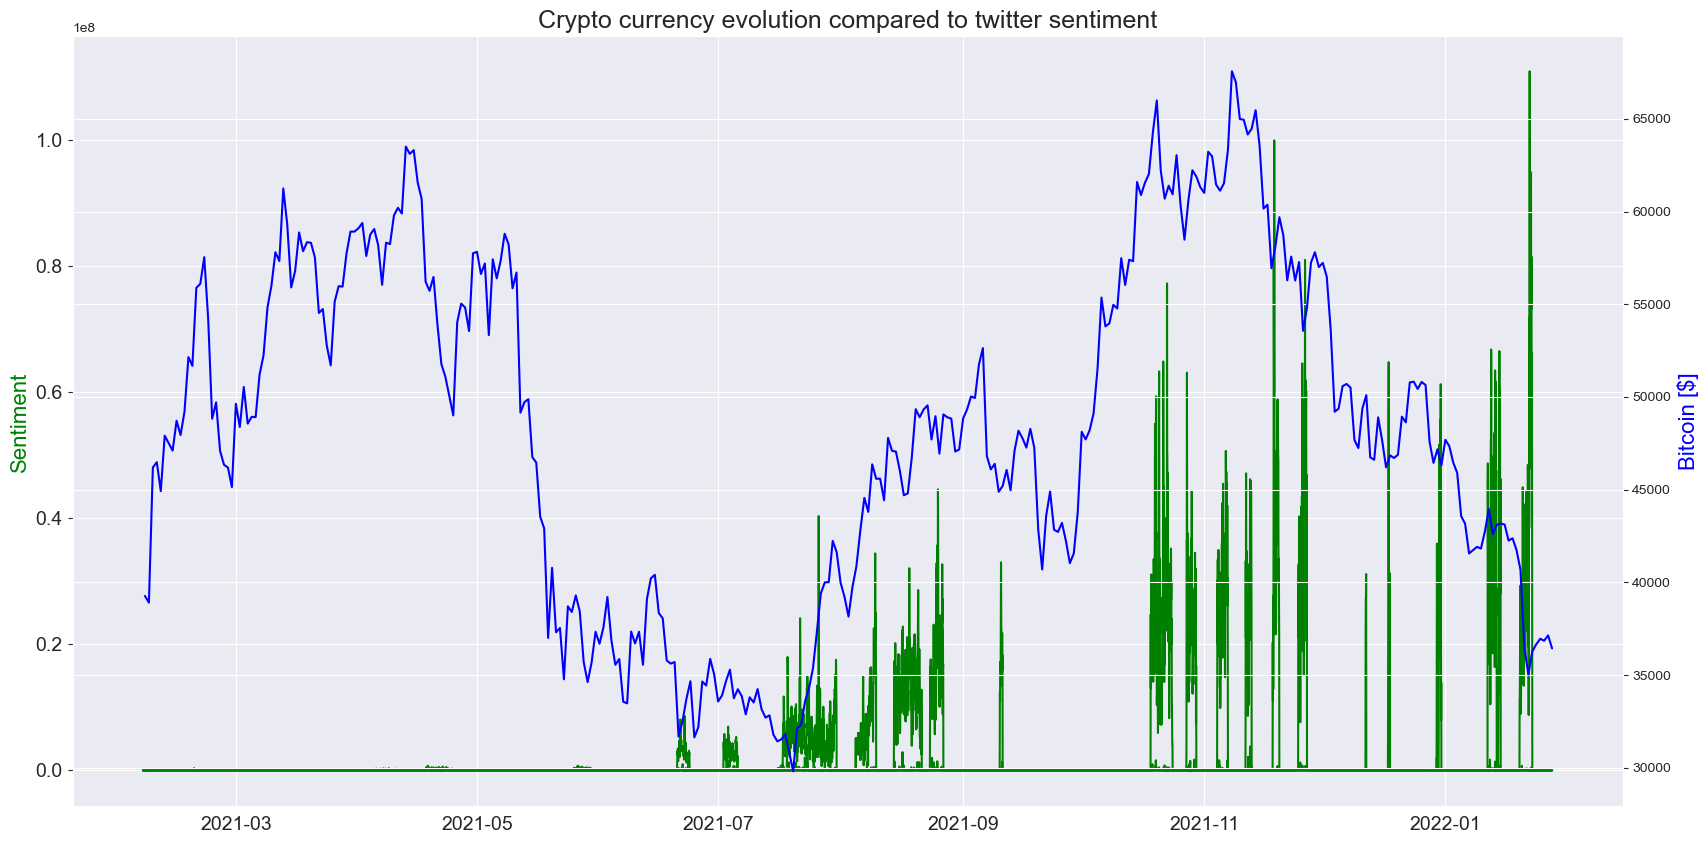

In [30]:
# cross correlation analysis
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

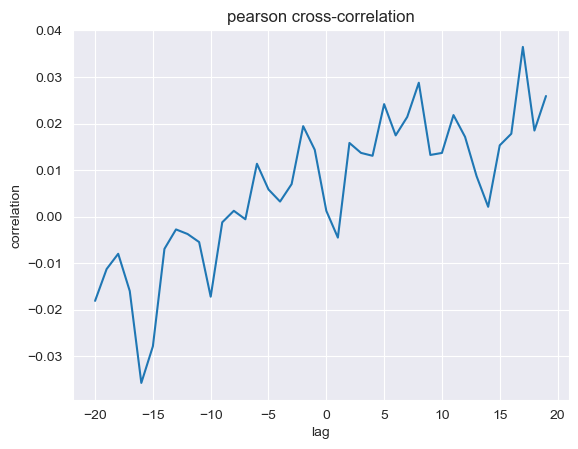

In [32]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()


## Normalization

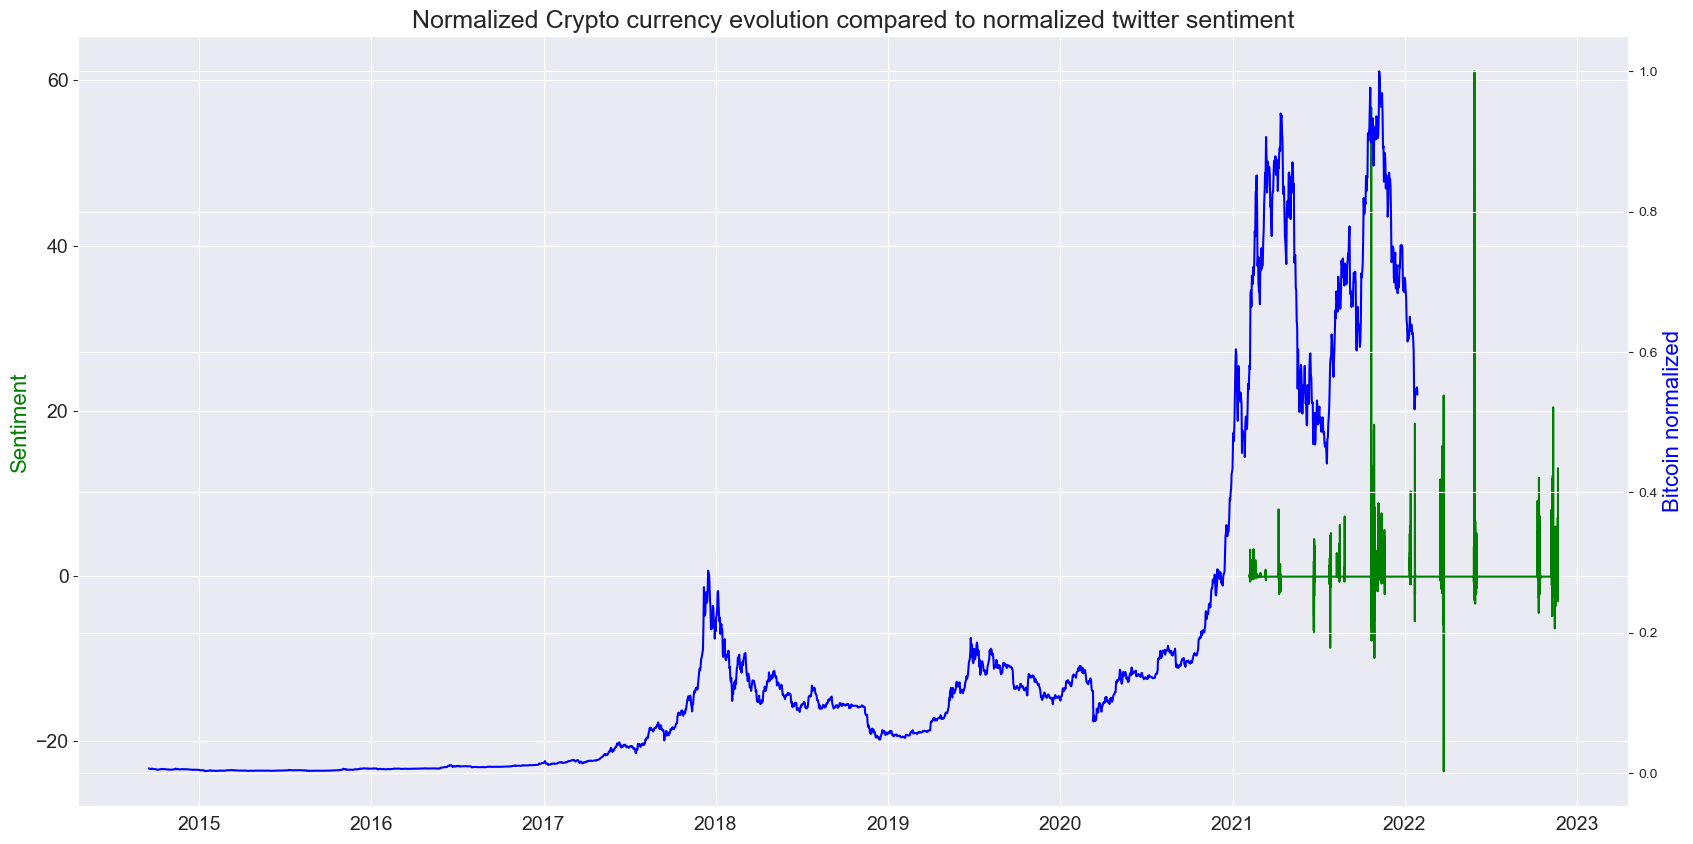

In [124]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

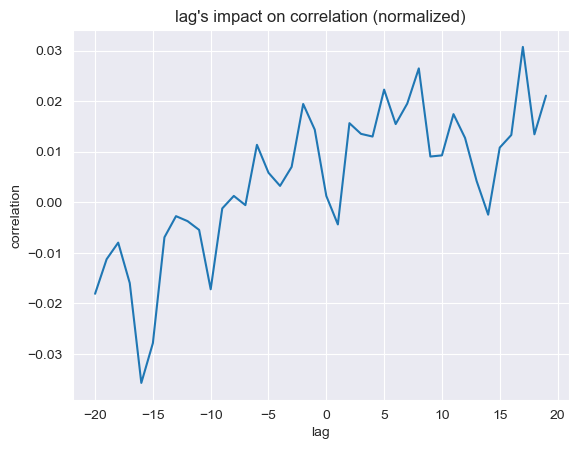

In [125]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Crypto price 

In [19]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

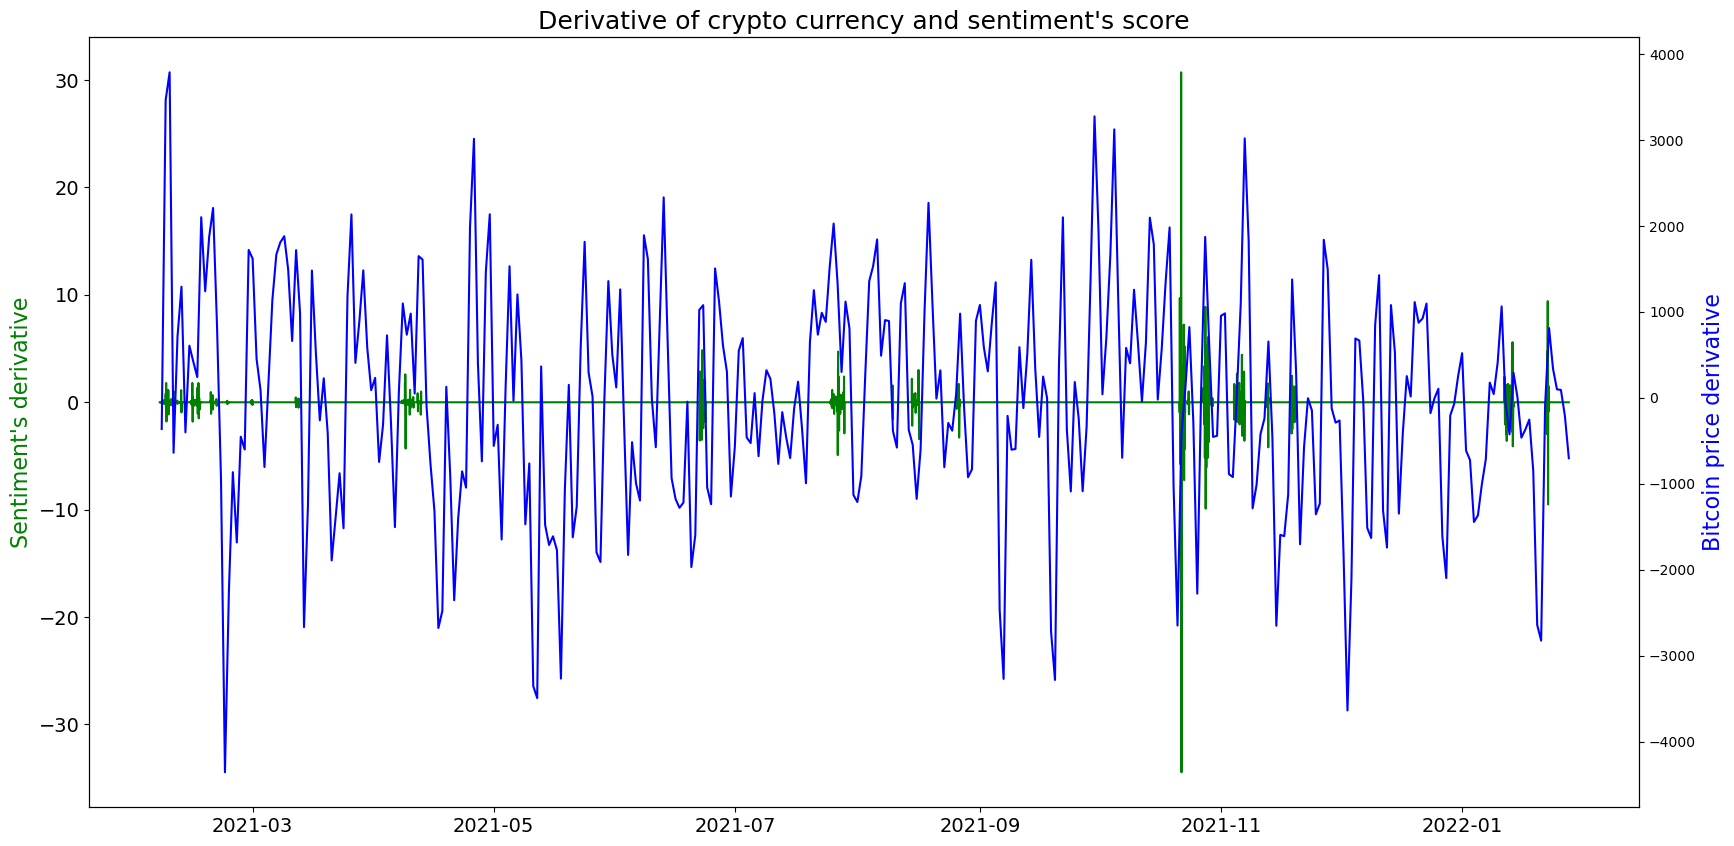

In [20]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

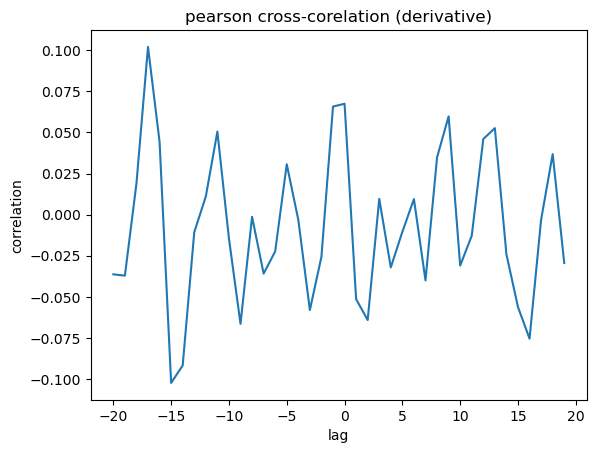

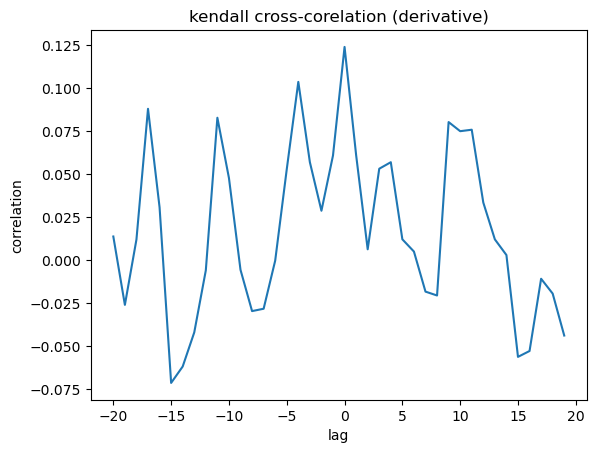

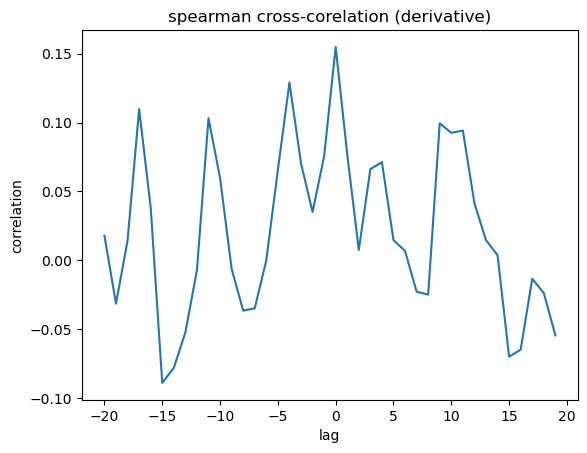

In [21]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

# Part 2 NLP Modeling

In [ ]:
! pip install textblob

In [15]:
from textblob import TextBlob

df = df_clean.copy()
# remove missing tag
df.dropna(subset=['hashtags'], inplace=True)
df = df[['text']] 
df.columns = ['tweets']
# keeps textual features
df.head()

KeyboardInterrupt: 

In [17]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words(['english'])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yedih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

def cleaning(data):
    #remove urls
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #3. Remove mentions and characters that not in the English alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    #2. Tokenize
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #3. Remove Puncs
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]

    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #5. lemma
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #6. Joining
    return " ".join(text_cleaned)

In [20]:
df['cleaned_tweets'] = df['tweets'].apply(cleaning)
# get date
df['date'] = df_clean['date']
df['date_clean'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df.drop(columns='date',inplace=True)
df.head()

,tweets,cleaned_tweets,date_clean
0,"enter economic downturn , jobs underserved are...",enter economic downturn job underserved area c...,2022-06-15
1,Crypto Strategy ICONOMI outperformed BTC . Che...,Crypto Strategy ICONOMI outperformed BTC Check...,2022-11-16
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12
6,zesty faucet making tweet claim free Lightning...,zesty faucet making tweet claim free Lightning...,2022-05-12
10,believe faithful project.The projector lot att...,believe faithful project The projector lot att...,2021-07-03


In [21]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [131]:
def crypto_price_cate(score):
    if score < 1:
        return 'negative'
    elif score == 1:
        return 'neutral'
    else:
        return 'positive'
def observe_period(period):
    # shift 'period' days
    res = crypto_usd_grouped.shift(period)/crypto_usd_grouped
    # compare to 'period' days before, increase? decrease?
    res = res.apply(crypto_price_cate)
    return res 

time_sentiment = observe_period(2) # compare price ratio in 7 days. price_7_days_later/ price_now
# if exist, get time sentiment for cypto_sentiment, else nan
df['crypto_sentiment'] = df.date_clean.apply(lambda x: time_sentiment[x] if x in time_sentiment else np.nan)

In [132]:
# may takes time 
df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity
0,"enter economic downturn , jobs underserved are...",enter economic downturn job underserved area c...,2022-06-15,NaN,0.40000,0.2
1,Crypto Strategy ICONOMI outperformed BTC . Che...,Crypto Strategy ICONOMI outperformed BTC Check...,2022-11-16,NaN,0.00000,0.0
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.6
6,zesty faucet making tweet claim free Lightning...,zesty faucet making tweet claim free Lightning...,2022-05-12,NaN,0.80000,0.4
10,believe faithful project.The projector lot att...,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.5


In [133]:
def getSentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['polarity'].apply(getSentiment)
df['target'] = df['sentiment'] == df['crypto_sentiment']
df.head()

,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
0,"enter economic downturn , jobs underserved are...",enter economic downturn job underserved area c...,2022-06-15,NaN,0.40000,0.2,positive,False
1,Crypto Strategy ICONOMI outperformed BTC . Che...,Crypto Strategy ICONOMI outperformed BTC Check...,2022-11-16,NaN,0.00000,0.0,neutral,False
5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.6,positive,False
6,zesty faucet making tweet claim free Lightning...,zesty faucet making tweet claim free Lightning...,2022-05-12,NaN,0.80000,0.4,positive,False
10,believe faithful project.The projector lot att...,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.5,positive,False


In [134]:
df.to_csv('./df_data.csv')

## Model preparation 

In [135]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [136]:
df = pd.read_csv('./df_data.csv')

In [137]:
df.dropna(subset=['crypto_sentiment'], inplace=True)
df.head()

,Unnamed: 0,tweets,cleaned_tweets,date_clean,crypto_sentiment,subjectivity,polarity,sentiment,target
2,5,2 Cryptocurrencies Trounced bitcoin Shiba Inu ...,Cryptocurrencies Trounced bitcoin Shiba Inu Cr...,2022-01-12,negative,0.90000,0.600,positive,False
4,10,believe faithful project.The projector lot att...,believe faithful project The projector lot att...,2021-07-03,negative,0.38125,0.500,positive,False
7,14,Bears optimistic Bitcoin long-time appreciatio...,Bears optimistic Bitcoin long time appreciatio...,2021-07-26,negative,0.55800,-0.088,negative,True
10,18,Ben Verlander reflects Miguel Cabrera 's histo...,Ben Verlander reflects Miguel Cabrera historic...,2021-08-24,positive,0.05000,0.000,neutral,False
12,24,40 minutes btc bitcoin eth Ethereum NFTs NFT N...,minute btc bitcoin eth Ethereum NFTs NFT NFTCo...,2021-11-19,positive,0.00000,0.000,neutral,False


## Model1

In [191]:
X = df['cleaned_tweets']
y = pd.get_dummies(df['crypto_sentiment']).values
num_classes = df['crypto_sentiment'].nunique()

In [192]:
seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17833,) (4459,) (17833, 2) (4459, 2)


In [193]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [194]:
from tensorflow.keras.preprocessing import sequence
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(17833, 30) (4459, 30)


In [195]:
from keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 32
epochs = 5

max_features = 20000
embed_dim = 100

weight_decay = 1e-4

np.random.seed(seed)
K.clear_session()
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
#model.add(Dropout(0.3))
#model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2))
#model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.learning_rate = 1e-4
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2000000   
                                                                 
 conv1d (Conv1D)             (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 32)            3104      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 6

In [49]:
!pip install pydot

In [196]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [197]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/5
558/558 - 10s - loss: 0.6863 - accuracy: 0.5527 - val_loss: 0.6819 - val_accuracy: 0.5690 - 10s/epoch - 18ms/step
Epoch 2/5
558/558 - 9s - loss: 0.6750 - accuracy: 0.5737 - val_loss: 0.6777 - val_accuracy: 0.5802 - 9s/epoch - 16ms/step
Epoch 3/5
558/558 - 9s - loss: 0.6568 - accuracy: 0.6040 - val_loss: 0.6668 - val_accuracy: 0.5934 - 9s/epoch - 15ms/step
Epoch 4/5
558/558 - 9s - loss: 0.6148 - accuracy: 0.6937 - val_loss: 0.6486 - val_accuracy: 0.6205 - 9s/epoch - 15ms/step
Epoch 5/5
558/558 - 8s - loss: 0.5399 - accuracy: 0.7728 - val_loss: 0.6424 - val_accuracy: 0.6221 - 8s/epoch - 15ms/step


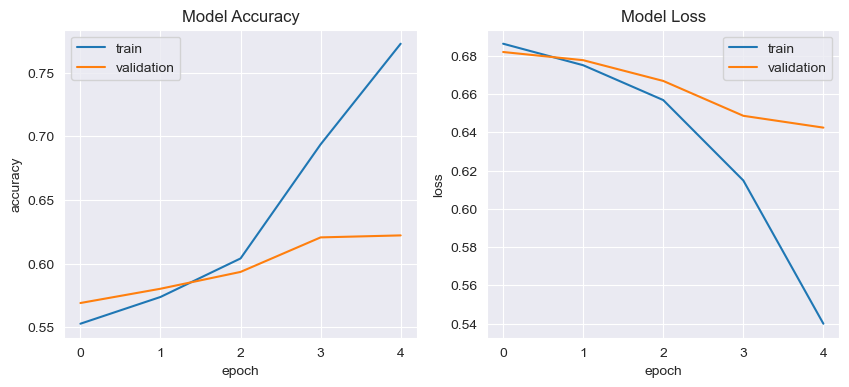

In [198]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [199]:
# predict class with test set
y_pred_test =  np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

140/140 [==============================] - 0s 1ms/step
Accuracy:	62.2%
              precision    recall  f1-score   support

           0       0.58      0.46      0.51      1923
           1       0.65      0.74      0.69      2536

    accuracy                           0.62      4459
   macro avg       0.61      0.60      0.60      4459
weighted avg       0.62      0.62      0.61      4459



140/140 [==============================] - 0s 1ms/step
1    2536
0    1923
dtype: int64
1    2913
0    1546
dtype: int64


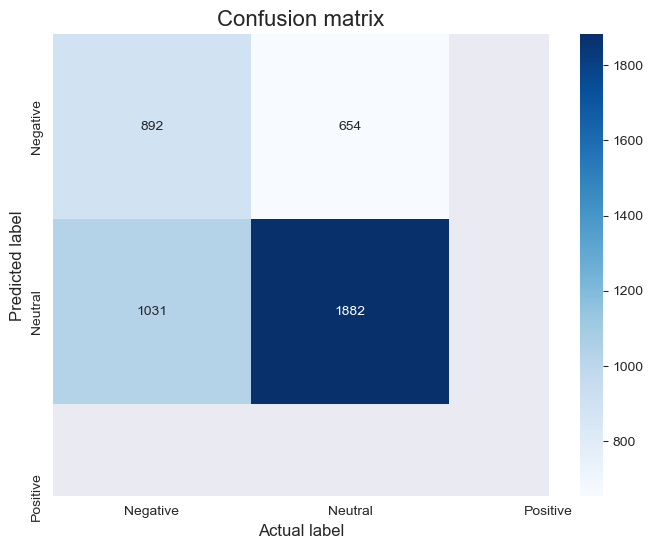

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Model2

In [202]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['cleaned_tweets']
y = pd.get_dummies(df['crypto_sentiment']).values
num_classes = df['crypto_sentiment'].nunique()

seed = 1 # fix random seed for reproducibility
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#max_features = 20000
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)

# BOWs
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

num_input = X_train.shape[1]
from tensorflow.keras.preprocessing import sequence

max_words = 30
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape, X_test.shape)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

batch_size = 32
epochs = 10

max_features = 20000
embed_dim = 100

np.random.seed(seed)
K.clear_session()
model = Sequential()
model = Sequential()
model.add(Dense(16, input_dim = num_input, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(16, activation='relu'))
#model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
#model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=2)


def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')


plot_training_hist(history)
# predict class with test set
y_pred_test = np.argmax(model.predict(X_test), axis=1)
print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100))
print(classification_report(np.argmax(y_test, axis=1), y_pred_test))
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1))

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)


plot_confusion_matrix(model, X_test, y_test)

(17833,) (4459,) (17833, 2) (4459, 2)
(17833, 34805) (4459, 34805)


ValueError: Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 16)